<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./214_AC_SAF_GOME-2_L3_AAI_load_browse.ipynb"><< 214 - AC SAF - GOME-2 - Level 3 - Absorbing Aerosol Index</a></span><span style="float:right;"><a href="./231_IASI_L2_load_browse.ipynb">231 - IASI - Level 2 >></a></span>

<div class="alert alert-block alert-success">
<b>20 - DATA DISCOVERY</b></div>

<hr>

# 2.2.1 GOME-2 - Level 2 - Polar Multi-Sensor Aerosol Optical Properties (PMAp) Product

The polar multi-sensor aerosol optical properties product (PMAp) provides information on aerosol optical depth (AOD) and aerosol type (fine mode, coarse mode (dust) and volcanic ash) over ocean and land surfaces.

The product is generated based on GOME-2 with support of information from AVHRR and IASI.

This module shows the structure of `GOME-2 Level 2 PMAp` data and what information of the data files can be used in order to load, browse and visualize the data.

PMAp data can be ordered via the EUMETSAT Data Centre and are distributed in `NetCDF`.



#### This module has the following outline:
- [Load and browse GOME-2 Level 2 PMAp data files](#pmap_load)
- [Load multiple PMAp data files as xarray DataArray object](#multiple_files)
- [Visualize PMAp data](#visualize)

#### Load required libraries

In [6]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb


from netCDF4 import Dataset
import pandas as pd
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [22]:
%run ../functions.ipynb

<hr>

## <a id='pmap_load'></a>Load and browe GOME-2 Level 2 PMAp data

GOME-2 Level 2 PMAp data is disseminated in the `NetCDF` format. You can use the [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) Python library to access and manipulate the data.

### Structure of GOME-2 Level 2 PMAp data files

The PMAp data files are structured in 15 groups:
* `conventions`
* `Data`
* `disposition_mode`
* `keywords`
* `metadata_conventions`
* `orbit_end`
* `orbit_start`
* `organization`
* `product_level`
* `product_name`
* `sensing_end_time_utc`
* `sensing_start_time_utc`
* `spacecraft`
* `Status`
* `summary`

Most groups provide metadata information. The group of interest that contains the data itself is `Data/MeasurementData`, which has the sub-groups `GeoData` and `ObservationData`:
* `MeasurementData`
  * `GeoData`
    * **aerosol_center_latitude**
    * **aerosol_center_longitude**
    * aerosol_corner_latitude
    * aerosol_corner_longitude
    * aerosol_sensor_readout_start_time
    * cloud_center_latitude
    * cloud_center_longitude
    * cloud_corner_latitude
    * cloud_corner_longitude
    * day
    * hour
    * minute
    * month
    * year
    * ...
  * `ObservationData`
    * `Aerosol`
      * **aerosol_class**
      * **aerosol_optical_depths**
      * aerosol_retrievals_flag
      * `Auxiliary`
    * `Cloud`
      * `Auxiliary`
      * cloud_optical_depth
      * cloud_retrieval_flags
      * cloud_top_temperature
    * `QualityInformation`
      * `AVHRR`
      * `ECMWF`
      * ...


Thus, the aerosol data information can be found under the group `ObservationData/Aerosol` and the corresponding geo information under the group `GeoData/`.

### Load a PMAp data file with the `netCDF4` library

With the `Dataset()` function of the `netCDF4` library, you can load a single file with the NetCDF format. PMAp data can be found in the eodata folder under `./gome2/pmap/`.

The resulting object is a `netCDF4.Dataset` object, which acts like a Python dictionary. Thus, with the `keys()` function you can list the different groups the file contains.

In [7]:
file_name = '../eodata/gome2/pmap/20191229/M01-GOME-GOMPMA02-NA-2.1-20191229004154.000000000Z-20191229013404-1379258.nc'
file = Dataset(file_name)
file.groups.keys()

dict_keys(['Data', 'Status'])

You can now select the `Data/MeasurementData/GeoData` group and get a list of available variables under this group.

In [8]:
file['Data/MeasurementData/GeoData'].variables.keys()

dict_keys(['year', 'month', 'day', 'hour', 'minute', 'aerosol_sensor_readout_start_time', 'cloud_sensor_readout_starttime', 'aerosol_corner_latitude', 'aerosol_corner_longitude', 'aerosol_center_latitude', 'aerosol_center_longitude', 'cloud_corner_latitude', 'cloud_corner_longitude', 'cloud_center_latitude', 'cloud_center_longitude', 'solar_zenith_angle', 'solar_azimuth_angle', 'platform_zenith_angle', 'platform_azimuth_angle', 'sensor_scan_angle', 'single_scattering_angle', 'relative_sensor_azimuth_angle'])

You can do the same for the group `Data/MeasurementData/ObservationData/Aerosol/`.

In [9]:
file['Data/MeasurementData/ObservationData/Aerosol'].variables.keys()

dict_keys(['aerosol_optical_depth', 'error_aerosol_optical_depth', 'aerosol_class', 'flag_ash', 'pmap_geometric_cloud_fraction', 'chlorophyll_pigment_concentration', 'aerosol_retrievals_flag'])

<br>

## <a id='multiple_files'></a>Load multiple PMAp data files as xarray DataArray object

For easier handling and plotting of the PMAp data, you can combine geolocation information and aerosol data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

You can make use of the function [load_l2_data_xr](../functions.ipynb#load_l2_data_xr), which loads a Level 2 dataset and returns a xarray DataArray with all the ground pixels of all files in a directory.

The function takes following arguments:
* `directory`: directory where the HDF file(s) are stored
* `internal_filepath`: internal path of the data variable that is of interest, e.g. Data/MeasurementData/ObservationData/Aerosol/
* `parameter`: paramter that is of interest, e.g. aerosol_optical_depth
* `lat_path`: path of the latitude variable
* `lon_path`: path of the longitude variable
* `no_of_dims`: number of dimensions of input array
* `paramname`: name of the parameter, preferable taken from the data file
* `unit`: unit of the parameter, preferably taken from the data file
* `longname`: longname of the parameter, preferably taken from the data file


Let us start with the retrieval of the `Aerosol Optical Depth` information from the data file loaded above. From there, you are able to retrieve the parameter's attributes for `Units`, `Standard_name` and `Long_name`.

In [12]:
aod = file['Data/MeasurementData/ObservationData/Aerosol/aerosol_optical_depth']
aod

<class 'netCDF4._netCDF4.Variable'>
>f8 aerosol_optical_depth(number_of_measurements)
    Units: 1
    Standard_name: aerosol_optical_depth
    Long_name: AOD_aerosol_optical_depth_at_550nm
    Comments: Aerosol Optical Depth (AOD) at 550nm
path = /Data/MeasurementData/ObservationData/Aerosol
unlimited dimensions: 
current shape = (119616,)
filling on, default _FillValue of 9.969209968386869e+36 used

The next step is to construct a `xarray.DataArray` by using the [load_l2_data_xr](../functions.ipynb#load_l2_data_xr) function. We define the objects `latpath`, `lonpath` and `internal_filepath`.

In [17]:
directory='../eodata/gome2/pmap/20191231/'

latpath='Data/MeasurementData/GeoData/aerosol_center_latitude'
lonpath='Data/MeasurementData/GeoData/aerosol_center_longitude'
internal_filepath='Data/MeasurementData/ObservationData/Aerosol'

Let us construct the DataArray object and call it `aod_xr`. The resulting object is a one-dimensional `xarray.DataArray` with more than 4 Mio ground pixel values and latitude and longitude as coordinate information.

In [18]:
aod_xr=load_l2_data_xr(directory=directory, 
                    internal_filepath=internal_filepath,
                    parameter='aerosol_optical_depth', 
                    lat_path=latpath, 
                    lon_path=lonpath, 
                    no_of_dims=1,
                    paramname=aod.Standard_name,
                    unit=aod.Units,
                    longname=aod.Long_name)

aod_xr

<xarray.DataArray 'aerosol_optical_depth' (ground_pixel: 4732032)>
array([-999.999999, -999.999999, -999.999999, ..., -999.999999,
       -999.999999, -999.999999])
Coordinates:
    latitude   (ground_pixel) float64 54.61 54.65 54.68 ... 60.12 60.12 60.13
    longitude  (ground_pixel) float64 -8.34 -8.453 -8.564 ... -12.88 -13.01
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  AOD_aerosol_optical_depth_at_550nm
    units:      1

## <a id='visualize'></a> Visualize PMAp data

The final step is to visualize the PMAp data. Since the final data object is a one-dimensional `xarray.DataArray`, you can take advantage of the function [visualize_scatter](../functions.ipynb#visualize_scatter). The function creates a matplotlib scatter plot.

The function takes the following arguments as input:
* `xr_dataarray`: your xarray data object
* `conversion factor`: conversion factor in case the data values are very small, otherwise it is 1
* `projection`: cartopy projection
* `vmin`: minimum number on visualisation legend
* `vmax`: maximum number on visualisation legend
* `point size`: size of the marker
* `color scale`: color palette
* `unit`: unit of the variable
* `title`: long name of the variable
* `set_global`: if yes, the resulting plot will have a global coverage


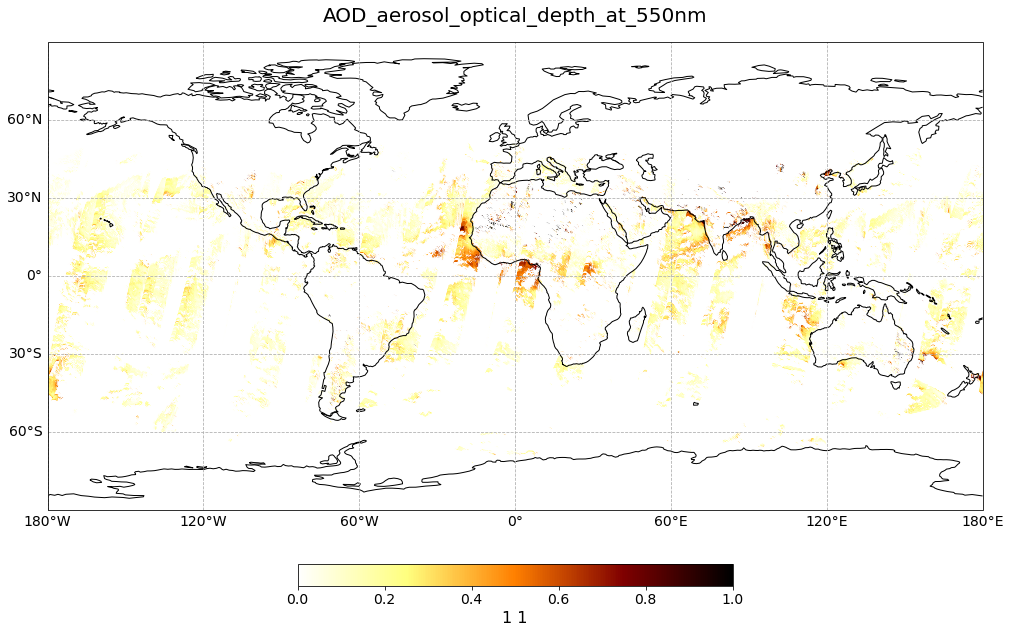

In [23]:
visualize_scatter(xr_dataarray=aod_xr, 
                  conversion_factor=1, 
                  projection=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=1, 
                  point_size=10,
                  color_scale='afmhot_r', 
                  unit=aod.Units, 
                  title=aod.Long_name,
                  set_global=True)

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./214_AC_SAF_GOME-2_L3_AAI_load_browse.ipynb"><< 214 - AC SAF - GOME-2 - Level 3 - Absorbing Aerosol Index</a></span><span style="float:right;"><a href="./231_IASI_L2_load_browse.ipynb">231 - IASI - Level 2 >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>